Steps:
1. Take the full signal and randomly pick N trials
2. Calculate Pearson trial-average
3. Calculate STTC trial-average
4. Calculate STTC on concatenated data
5. Compare 2,3,4, values calculated on full signal, and ground truth

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 

import numpy as np
from random import randrange
# IP import warnings because of "module 'numpy' has no attribute 'warnings'"
import warnings
np.warnings = warnings
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from scipy.optimize import curve_fit, OptimizeWarning
#from sklearn.metrics import r2_score

# import from scripts
import os
#os.chdir(os.path.expanduser("D:\\intr_timescales\\isttc\\scripts"))
os.chdir(os.path.expanduser("C:\\Users\\ipoch\\Documents\\repos\\isttc\\scripts"))
from calculate_acf import acf_sttc, acf_pearsonr_trial_avg, acf_sttc_trial_avg, acf_sttc_trail_concat

### Load the data

In [2]:
spike_times = np.load('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split\\spike_times.npy')
ou_spiketrain_binned = np.load('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split\\ou_spiketrain_binned.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split\\spike_times.npy'

In [3]:
num_lags = 20
bin_size = 50
sttc_dt = 49
signal_len = 100000

In [4]:
def func_exp_abc_like(x, a, tau):
    return a * np.exp(-x/tau) 

def func_single_exp_monkey_like(x, a, b, c):
    #return a * np.exp(-b * x) + c
    return a * (np.exp(-b * x) + c) # as in the paper

### Calculate acf and sttc for the full signal

In [5]:
t_axes = np.linspace(0,num_lags,num_lags+1).astype(int)
print(t_axes)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [ ]:
# Using acf func
spike_train_binned_acf = acf(ou_spiketrain_binned[0], nlags=num_lags)
print('spike_train_binned_acf shape {}, \nspike_train_binned_acf: {}'.format(spike_train_binned_acf.shape, spike_train_binned_acf))

# Using isttc
spike_train_acf = acf_sttc(spike_times, num_lags, lag_shift_=bin_size, sttc_dt_=sttc_dt, signal_length_=signal_len, verbose_=False)
print('spike_train_acf shape {}, \nspike_train_acf: {}'.format(len(spike_train_acf), spike_train_acf))

# calculate tau
spike_train_binned_popt, _ = curve_fit(func_single_exp_monkey_like, t_axes, spike_train_binned_acf, maxfev=5000)
spike_train_binned_tau_ms = (1/spike_train_binned_popt[1]) * bin_size
print('spike_train_binned_popt: {}, spike_train_binned_tau_ms: {}'.format(spike_train_binned_popt, spike_train_binned_tau_ms))

spike_train_popt, _ = curve_fit(func_single_exp_monkey_like, t_axes, spike_train_acf, maxfev=5000)
spike_train_tau_ms = (1/spike_train_popt[1]) * bin_size
print('spike_train_popt: {}, spike_train_tau_ms: {}'.format(spike_train_popt, spike_train_tau_ms))

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(8,3))

axes[0].plot(t_axes, spike_train_binned_acf, c='orange', label='acf')
axes[0].plot(t_axes, func_single_exp_monkey_like(t_axes, spike_train_binned_popt[0], spike_train_binned_popt[1], spike_train_binned_popt[2]), 
             label='fitted')
axes[0].axvline(x=spike_train_binned_popt[1], lw=0.5, color='red')
axes[0].set_title('ACF, tau={}, diff={}'.format(np.round(spike_train_binned_tau_ms, 2), np.round(100-spike_train_binned_tau_ms, 2)))
axes[0].set_xticks(np.linspace(0,20,6))
axes[0].set_xticklabels(np.linspace(0,1000,6).astype(int))

axes[1].plot(t_axes, spike_train_acf, c='orange', label='isttc')
axes[1].plot(t_axes, func_single_exp_monkey_like(t_axes, spike_train_popt[0], spike_train_popt[1], spike_train_popt[2]), label='fitted')
axes[1].axvline(x=spike_train_popt[1], lw=0.5, color='red')
axes[1].set_title('iSTTC, tau={}, diff={}'.format(np.round(spike_train_tau_ms, 2), np.round(100-spike_train_tau_ms, 2)))
axes[1].set_xticks(np.linspace(0,20,6))
axes[1].set_xticklabels(np.linspace(0,1000,6).astype(int))

fig.suptitle('Full signal', y=1.05)

for ax in axes.flat:
    ax.legend(frameon=False)
    ax.axvline(x=2, lw=0.5, color='k')
    ax.axhline(y=0, lw=0.5, color='k')
    ax.set_xlabel('Time')
    ax.set_ylabel('ACF')

sns.despine()

#fig.savefig('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split\\figs\\' + 'full_signal.png' , bbox_inches='tight')

### Make trials

In [ ]:
def get_trials(spike_times_, signal_len_, n_trials_, trial_len_, verbose_=False):
    # get random trail starts and ends
    trials_start = [randrange(0, signal_len_-trial_len_+1) for i in range(n_trials_)]
    trials_end = [trial_start + trial_len_ for trial_start in trials_start]
    trial_intervals = np.vstack((trials_start, trials_end)).T
    if verbose_:
        print('N trials {}, trail len {}, n trial starts {}, \ntrial starts {}, \ntrial starts {}'.format(n_trials_, trial_len_, 
                                                                                                          len(trials_start), 
                                                                                                          trials_start, trials_end))
    # get spikes
    spikes_trials = []
    for i in range(n_trials_):
        spikes_trial = spike_times_[np.logical_and(spike_times_ >= trial_intervals[i,0], spike_times_ < trial_intervals[i,1])]
        spikes_trials.append(spikes_trial)

    # realign all trails to start with 0
    spikes_trials_realigned_l = []
    for idx, trial in enumerate(spikes_trials):
        spikes_trial_realigned = trial - trial_intervals[idx,0] 
        spikes_trials_realigned_l.append(spikes_trial_realigned)

    return spikes_trials_realigned_l

def bin_trials(spikes_trials_l_, trial_len_, bin_size_):
    binned_spikes_trials_l = []

    n_bin_edges =  int(trial_len_/bin_size_)
    bins_ = np.linspace(0, bin_size * n_bin_edges, n_bin_edges + 1).astype(int)
    for trial in spikes_trials_l_:
        binned_spike_train, _ = np.histogram(trial, bins_)
        binned_spikes_trials_l.append(binned_spike_train)
    binned_spikes_trials_2d = np.asarray(binned_spikes_trials_l)

    return binned_spikes_trials_2d

### Run for one trial realization

In [ ]:
n_trials = 30
trial_len = num_lags * bin_size

#spikes_trials_30 = get_trials(spike_times, signal_len, n_trials, trial_len, verbose_=False)
#spikes_trials_30_binned = bin_trials(spikes_trials_30, trial_len, bin_size)

In [ ]:
# np.save('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split\\trials_30_runs_1\\spikes_trials_30.npy', 
#         np.asarray(spikes_trials_30, dtype='object'))
# np.save('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split\\trials_30_runs_1\\spikes_trials_30_binned.npy', 
#         spikes_trials_30_binned, allow_pickle=True)

In [ ]:
spikes_trials_30 = np.load('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split\\trials_30_runs_1\\spikes_trials_30.npy', 
                           allow_pickle=True)
spikes_trials_30_binned = np.load('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split\\trials_30_runs_1\\spikes_trials_30_binned.npy')

In [ ]:
# Pearson trial-average
acf_matrix_trail_avg, acf_average_trial_avg = acf_pearsonr_trial_avg(spikes_trials_30_binned, n_lags_=num_lags)
spike_train_trial_avg_popt, _ = curve_fit(func_single_exp_monkey_like, np.linspace(0,19,20), acf_average_trial_avg, maxfev=5000)
spike_train_trial_avg_tau_ms = (1/spike_train_trial_avg_popt[1]) * bin_size
print(spike_train_trial_avg_tau_ms)

# STTC trial-average
sttc_matrix_trail_avg, sttc_average_trial_avg = acf_sttc_trial_avg(spikes_trials_30, 
                                                                   lag_shift_=bin_size, 
                                                                   zero_padding_len_=120, 
                                                                   fs_=1000, 
                                                                   sttc_dt_=sttc_dt, 
                                                                   verbose_=False)
spike_train_trial_avg_sttc_popt, _ = curve_fit(func_single_exp_monkey_like, np.linspace(0,19,20), sttc_average_trial_avg, maxfev=5000)
spike_train_trial_avg_sttc_tau_ms = (1/spike_train_trial_avg_sttc_popt[1]) * bin_size
print(spike_train_trial_avg_sttc_tau_ms)

# STTC concat
acf_sttc_trial_concat_v2 = acf_sttc_trail_concat(spikes_trials_30, 
                                                                      n_lags_ = num_lags,
                                                                      lag_shift_=bin_size, 
                                                                      sttc_dt_=sttc_dt, 
                                                                      trial_len_=trial_len, 
                                                                      zero_padding_len_=2000,
                                                                      verbose_=False)
spike_train_trial_concat_sttc_v2_popt, _ = curve_fit(func_single_exp_monkey_like, np.linspace(0,num_lags-1,num_lags), acf_sttc_trial_concat_v2, maxfev=5000)
spike_train_trial_concat_sttc_v2_tau_ms = (1/spike_train_trial_concat_sttc_v2_popt[1]) * bin_size
print(spike_train_trial_concat_sttc_v2_tau_ms)

### Run for multiple realizations

In [ ]:
### Run for 100 realizations
n_stims = 500

n_trials = 100
trial_len = num_lags * bin_size

pearson_avg_l = []
sttc_avg_l = []
sttc_concat_l = []
stim_l = []

for i in range(n_stims):
    print(f'Run {i}')
    spikes_trials_stim = get_trials(spike_times, signal_len, n_trials, trial_len, verbose_=False)
    spikes_trials_binned_stim = bin_trials(spikes_trials_stim, trial_len, bin_size)

    np.save('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split\\trials_100_runs_500\\spikes_trials_stim_run' + str(i) 
            + '.npy', np.asarray(spikes_trials_stim, dtype='object'))
    np.save('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split\\trials_100_runs_500\\spikes_trials_binned_stim' + str(i) 
            + '.npy', spikes_trials_binned_stim, allow_pickle=True)

    # Pearson trial-average
    acf_matrix_trail_avg, acf_average_trial_avg = acf_pearsonr_trial_avg(spikes_trials_binned_stim, n_lags_=num_lags, verbose_=False)
    spike_train_trial_avg_popt, _ = curve_fit(func_single_exp_monkey_like, np.linspace(0,19,20), acf_average_trial_avg, maxfev=5000)
    spike_train_trial_avg_tau_ms = (1/spike_train_trial_avg_popt[1]) * bin_size
    #print(spike_train_trial_avg_tau_ms)
    
    # STTC trial-average
    sttc_matrix_trail_avg, sttc_average_trial_avg = acf_sttc_trial_avg(spikes_trials_stim, 
                                                                       lag_shift_=bin_size, 
                                                                       zero_padding_len_=120, 
                                                                       fs_=1000, 
                                                                       sttc_dt_=sttc_dt, 
                                                                       verbose_=False)
    spike_train_trial_avg_sttc_popt, _ = curve_fit(func_single_exp_monkey_like, np.linspace(0,19,20), sttc_average_trial_avg, maxfev=5000)
    spike_train_trial_avg_sttc_tau_ms = (1/spike_train_trial_avg_sttc_popt[1]) * bin_size
    #print(spike_train_trial_avg_sttc_tau_ms)

    # STTC concat v3
    acf_sttc_trial_concat = acf_sttc_trail_concat(spikes_trials_stim, 
                                                                          n_lags_ = num_lags,
                                                                          lag_shift_=bin_size, 
                                                                          sttc_dt_=sttc_dt, 
                                                                          trial_len_=trial_len, 
                                                                          zero_padding_len_=2000,
                                                                          verbose_=False)
    spike_train_trial_concat_sttc_popt, _ = curve_fit(func_single_exp_monkey_like, np.linspace(0,num_lags-1,num_lags), acf_sttc_trial_concat, maxfev=5000)
    spike_train_trial_concat_sttc_tau_ms = (1/spike_train_trial_concat_sttc_popt[1]) * bin_size
    #print(spike_train_trial_concat_sttc_v2_tau_ms)

    stim_l.append(i)
    pearson_avg_l.append(spike_train_trial_avg_tau_ms)
    sttc_avg_l.append(spike_train_trial_avg_sttc_tau_ms)
    sttc_concat_l.append(spike_train_trial_concat_sttc_tau_ms)

In [ ]:
tau_df = pd.DataFrame(np.vstack((stim_l, pearson_avg_l, sttc_avg_l, sttc_concat_l)).T, 
                      columns=['run_id', 'tau_pearsonr_avg', 'tau_sttc_avg', 'tau_sttc_concat'])
tau_df_long = pd.melt(tau_df, id_vars=['run_id'], value_vars=['tau_pearsonr_avg', 'tau_sttc_avg', 'tau_sttc_concat'], 
                      value_name='tau_ms', var_name='method')

In [ ]:
tau_df.describe()

In [ ]:
tau_df.to_pickle('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split\\trials_100_runs_500\\tau_df.pkl')

In [ ]:
tau_df

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,3))

sns.violinplot(ax=axes[0], x='method', y='tau_ms', data=tau_df_long, cut=0,  density_norm='width')
axes[0].axhline(y=100, color='k')

sns.violinplot(ax=axes[1], x='method', y='tau_ms', data=tau_df_long, cut=0,  density_norm='width')
axes[1].axhline(y=100, color='k')
axes[1].set_yscale('log')

fig.suptitle('trials_100_runs_500, tau=100. Median: P_avg: {}, STTC_avg: {}, STTC_concat: {}'
             .format(np.round(np.nanmedian(tau_df['tau_pearsonr_avg'].values), 2),
             np.round(np.nanmedian(tau_df['tau_sttc_avg']), 2), np.round(np.nanmedian(tau_df['tau_sttc_concat']), 2)), y=1.05)

sns.despine()

fig.savefig('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split\\trials_100_runs_500\\' 
            + 'taus.png' , bbox_inches='tight')

### Calculate on 100 signals

In [8]:
#dataset_folder = 'Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split_parametric\\dataset\\'
dataset_folder = 'D:\\isttc\\results\\synthetic_data\\test_full_split_parametric\\dataset\\'

n_signals = 100

acf_full = []
sttc_full = []
pearsonr_avg_trial_med = []
sttc_avg_trial_med = []
sttc_concat_trial_med = []

for i in range(50):
    print('Processing {}'.format(i))
    print(dataset_folder + 'spike_times_' + str(i) + '.npy')
    print(dataset_folder + 'spike_times_binned_' + str(i) + '.npy')

    spike_times = np.load(dataset_folder + 'spike_times_' + str(i) + '.npy')
    ou_spiketrain_binned = np.load(dataset_folder + 'spike_times_binned_' + str(i) + '.npy')

    # on full signal
    # Using acf func
    spike_train_binned_acf = acf(ou_spiketrain_binned[0], nlags=num_lags)
    #print('spike_train_binned_acf shape {}, \nspike_train_binned_acf: {}'.format(spike_train_binned_acf.shape, spike_train_binned_acf))
    spike_train_binned_popt, _ = curve_fit(func_single_exp_monkey_like, t_axes, spike_train_binned_acf, maxfev=5000)
    spike_train_binned_tau_ms = (1/spike_train_binned_popt[1]) * bin_size
    #print('spike_train_binned_popt: {}, spike_train_binned_tau_ms: {}'.format(spike_train_binned_popt, spike_train_binned_tau_ms))
    acf_full.append(spike_train_binned_tau_ms)
    
    # Using isttc
    spike_train_acf = acf_sttc(spike_times, num_lags, lag_shift_=bin_size, sttc_dt_=sttc_dt, signal_length_=signal_len, verbose_=False)
    #print('spike_train_acf shape {}, \nspike_train_acf: {}'.format(len(spike_train_acf), spike_train_acf))
    spike_train_popt, _ = curve_fit(func_single_exp_monkey_like, t_axes, spike_train_acf, maxfev=5000)
    spike_train_tau_ms = (1/spike_train_popt[1]) * bin_size
    #print('spike_train_popt: {}, spike_train_tau_ms: {}'.format(spike_train_popt, spike_train_tau_ms))
    sttc_full.append(spike_train_tau_ms)

    # # on trials
    # ### Run for 500 realizations
    # n_stims = 50
    
    # n_trials = 30
    # trial_len = num_lags * bin_size
    
    # pearson_avg_l = []
    # sttc_avg_l = []
    # sttc_concat_l = []
    # stim_l = []
    
    # for j in range(n_stims):
    #     #print(f'Run {j}')
    #     spikes_trials_stim = get_trials(spike_times, signal_len, n_trials, trial_len, verbose_=False)
    #     spikes_trials_binned_stim = bin_trials(spikes_trials_stim, trial_len, bin_size)
    
    #     # np.save('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split\\trials_100_runs_500\\spikes_trials_stim_run' + str(i) 
    #     #         + '.npy', np.asarray(spikes_trials_stim, dtype='object'))
    #     # np.save('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split\\trials_100_runs_500\\spikes_trials_binned_stim' + str(i) 
    #     #         + '.npy', spikes_trials_binned_stim, allow_pickle=True)
    
    #     # Pearson trial-average
    #     acf_matrix_trail_avg, acf_average_trial_avg = acf_pearsonr_trial_avg(spikes_trials_binned_stim, n_lags_=num_lags, verbose_=False)
    #     spike_train_trial_avg_popt, _ = curve_fit(func_single_exp_monkey_like, np.linspace(0,19,20), acf_average_trial_avg, maxfev=5000)
    #     spike_train_trial_avg_tau_ms = (1/spike_train_trial_avg_popt[1]) * bin_size
    #     #print(spike_train_trial_avg_tau_ms)
        
    #     # STTC trial-average
    #     sttc_matrix_trail_avg, sttc_average_trial_avg = acf_sttc_trial_avg(spikes_trials_stim, 
    #                                                                        lag_shift_=bin_size, 
    #                                                                        zero_padding_len_=120, 
    #                                                                        fs_=1000, 
    #                                                                        sttc_dt_=sttc_dt, 
    #                                                                        verbose_=False)
    #     spike_train_trial_avg_sttc_popt, _ = curve_fit(func_single_exp_monkey_like, np.linspace(0,19,20), sttc_average_trial_avg, maxfev=5000)
    #     spike_train_trial_avg_sttc_tau_ms = (1/spike_train_trial_avg_sttc_popt[1]) * bin_size
    #     #print(spike_train_trial_avg_sttc_tau_ms)
    
    #     # STTC concat v3
    #     acf_sttc_trial_concat = acf_sttc_trail_concat(spikes_trials_stim, 
    #                                                                           n_lags_ = num_lags,
    #                                                                           lag_shift_=bin_size, 
    #                                                                           sttc_dt_=sttc_dt, 
    #                                                                           trial_len_=trial_len, 
    #                                                                           zero_padding_len_=2000,
    #                                                                           verbose_=False)
    #     spike_train_trial_concat_sttc_popt, _ = curve_fit(func_single_exp_monkey_like, np.linspace(0,num_lags-1,num_lags), acf_sttc_trial_concat, maxfev=5000)
    #     spike_train_trial_concat_sttc_tau_ms = (1/spike_train_trial_concat_sttc_popt[1]) * bin_size
    #     #print(spike_train_trial_concat_sttc_v2_tau_ms)
    
    #     stim_l.append(j)
    #     pearson_avg_l.append(spike_train_trial_avg_tau_ms)
    #     sttc_avg_l.append(spike_train_trial_avg_sttc_tau_ms)
    #     sttc_concat_l.append(spike_train_trial_concat_sttc_tau_ms)

    # tau_df = pd.DataFrame(np.vstack((stim_l, pearson_avg_l, sttc_avg_l, sttc_concat_l)).T, 
    #                   columns=['run_id', 'tau_pearsonr_avg', 'tau_sttc_avg', 'tau_sttc_concat'])

    # # tau_df.to_pickle('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split_parametric\\five_methods\\trial_tau_df\\tau_df_' 
    # #                      + str(i) + '.pkl')
    # tau_df.to_pickle('D:\\isttc\\results\\synthetic_data\\test_full_split_parametric\\five_methods_50\\trial_tau_df\\tau_df_' 
    #                  + str(i) + '.pkl')

    # pearsonr_avg_trial_med.append(np.nanmedian(pearson_avg_l))
    # sttc_avg_trial_med.append(np.nanmedian(sttc_avg_l))
    # sttc_concat_trial_med.append(np.nanmedian(sttc_concat_l))

    # # save the plot
    # tau_df_long = pd.melt(tau_df, id_vars=['run_id'], value_vars=['tau_pearsonr_avg', 'tau_sttc_avg', 'tau_sttc_concat'], 
    #                   value_name='tau_ms', var_name='method')
    
    # fig, axes = plt.subplots(1,2, figsize=(10,3))

    # sns.violinplot(ax=axes[0], x='method', y='tau_ms', data=tau_df_long, cut=0,  density_norm='width')
    # axes[0].axhline(y=100, color='k')
    
    # sns.violinplot(ax=axes[1], x='method', y='tau_ms', data=tau_df_long, cut=0,  density_norm='width')
    # axes[1].axhline(y=100, color='k')
    # axes[1].set_yscale('log')
    
    # fig.suptitle('trials_30_runs_500, tau=100. Median: P_avg: {}, STTC_avg: {}, STTC_concat: {}'
    #              .format(np.round(np.nanmedian(tau_df['tau_pearsonr_avg'].values), 2),
    #              np.round(np.nanmedian(tau_df['tau_sttc_avg']), 2), np.round(np.nanmedian(tau_df['tau_sttc_concat']), 2)), y=1.05)
    
    # sns.despine()
    
    # # fig.savefig('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split_parametric\\five_methods\\trial_tau_figs\\' 
    # #             + 'taus' + str(i) + '.png' , bbox_inches='tight')
    # fig.savefig('D:\\isttc\\results\\synthetic_data\\test_full_split_parametric\\five_methods_50\\trial_tau_figs\\' 
    #             + 'taus' + str(i) + '.png' , bbox_inches='tight')
        
    

Processing 0
D:\isttc\results\synthetic_data\test_full_split_parametric\dataset\spike_times_0.npy
D:\isttc\results\synthetic_data\test_full_split_parametric\dataset\spike_times_binned_0.npy
Initial time_abs: 384944
Total time: 100000, Time proportion: 0.67585
Initial time_abs: 384944
Total time: 100000, Time proportion: 0.67585
STTC: 1.0
Processing 1
D:\isttc\results\synthetic_data\test_full_split_parametric\dataset\spike_times_1.npy
D:\isttc\results\synthetic_data\test_full_split_parametric\dataset\spike_times_binned_1.npy
Initial time_abs: 416500
Total time: 100000, Time proportion: 0.66042
Initial time_abs: 416500
Total time: 100000, Time proportion: 0.66042
STTC: 1.0
Processing 2
D:\isttc\results\synthetic_data\test_full_split_parametric\dataset\spike_times_2.npy
D:\isttc\results\synthetic_data\test_full_split_parametric\dataset\spike_times_binned_2.npy
Initial time_abs: 403368
Total time: 100000, Time proportion: 0.66051
Initial time_abs: 403368
Total time: 100000, Time proportion

In [12]:
pearsonr_avg_trial_med = []
sttc_avg_trial_med = []
sttc_concat_trial_med = []

for k in range(50):
    tau_df = pd.read_pickle('D:\\isttc\\results\\synthetic_data\\test_full_split_parametric\\five_methods_50\\trial_tau_df\\tau_df_' + str(k) + '.pkl')
    pearsonr_avg_trial_med.append(np.nanmedian(tau_df['tau_pearsonr_avg']))
    sttc_avg_trial_med.append(np.nanmedian(tau_df['tau_sttc_avg']))
    sttc_concat_trial_med.append(np.nanmedian(tau_df['tau_sttc_concat']))

In [15]:
tau_5methods_df = pd.DataFrame(np.vstack((np.linspace(0,49, 50).astype(int), acf_full, sttc_full, 
                                         pearsonr_avg_trial_med, sttc_avg_trial_med, sttc_concat_trial_med)).T, 
                  columns=['signal_id', 'tau_acf_full', 'tau_sttc_full', 'tau_pearsonr_avg', 'tau_sttc_avg', 'tau_sttc_concat'])

In [16]:
tau_5methods_df.head(5)

,signal_id,tau_acf_full,tau_sttc_full,tau_pearsonr_avg,tau_sttc_avg,tau_sttc_concat
0,0.0,69.816249,99.166812,75.724865,78.331481,97.027163
1,1.0,106.021494,127.655374,108.045485,103.532708,117.727457
2,2.0,87.950148,107.773950,85.439910,88.475023,98.680907
3,3.0,93.769052,106.499382,91.975525,88.578144,100.346508
4,4.0,88.182288,101.844609,87.732293,82.713007,95.402283


In [28]:
tau_5methods_diff_df = pd.DataFrame(np.vstack((np.linspace(0,49, 50).astype(int),
                                               100-np.asarray(acf_full), 
                                               100-np.asarray(sttc_full), 
                                         100-np.asarray(pearsonr_avg_trial_med), 
                                               100-np.asarray(sttc_avg_trial_med), 
                                               100-np.asarray(sttc_concat_trial_med))).T, 
                  columns=['signal_id', 'tau_acf_full', 'tau_sttc_full', 'tau_pearsonr_avg', 'tau_sttc_avg', 'tau_sttc_concat'])

In [39]:
tau_5methods_diff_abs_df = pd.DataFrame(np.vstack((np.linspace(0,49, 50).astype(int),
                                               np.abs(100-np.asarray(acf_full)), 
                                               np.abs(100-np.asarray(sttc_full)), 
                                               np.abs(100-np.asarray(pearsonr_avg_trial_med)), 
                                               np.abs(100-np.asarray(sttc_avg_trial_med)), 
                                               np.abs(100-np.asarray(sttc_concat_trial_med)))).T, 
                  columns=['signal_id', 'tau_acf_full', 'tau_sttc_full', 'tau_pearsonr_avg', 'tau_sttc_avg', 'tau_sttc_concat'])

In [26]:
tau_5methods_df.to_pickle('D:\\isttc\\results\\synthetic_data\\test_full_split_parametric\\five_methods_50\\tau_5methods_df.pkl')

### ZZZZ

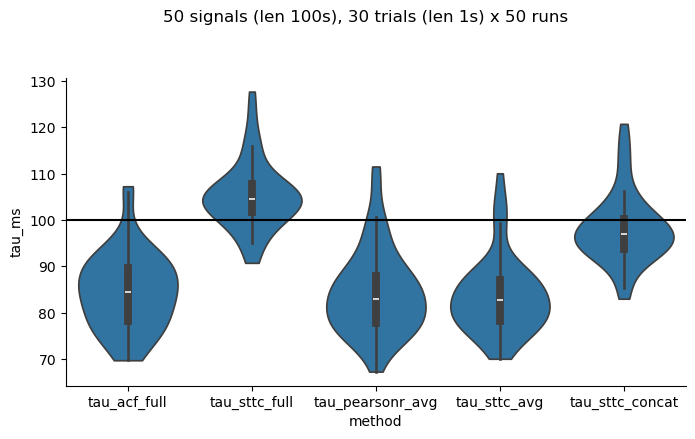

In [25]:
tau_5methods_df_long = pd.melt(tau_5methods_df, id_vars=['signal_id'], value_vars=['tau_acf_full', 'tau_sttc_full', 
                                                                                   'tau_pearsonr_avg', 'tau_sttc_avg', 'tau_sttc_concat'], 
                  value_name='tau_ms', var_name='method')

fig, axes = plt.subplots(1,1, figsize=(8,4))

sns.violinplot(ax=axes, x='method', y='tau_ms', data=tau_5methods_df_long, cut=0,  density_norm='width')
axes.axhline(y=100, color='k')

fig.suptitle('50 signals (len 100s), 30 trials (len 1s) x 50 runs', y=1.05)

sns.despine()

# fig.savefig('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split_parametric\\five_methods\\trial_tau_figs\\' 
#             + 'taus' + str(i) + '.png' , bbox_inches='tight')
fig.savefig('D:\\isttc\\results\\synthetic_data\\test_full_split_parametric\\five_methods_50\\' 
            + 'taus.png' , bbox_inches='tight')

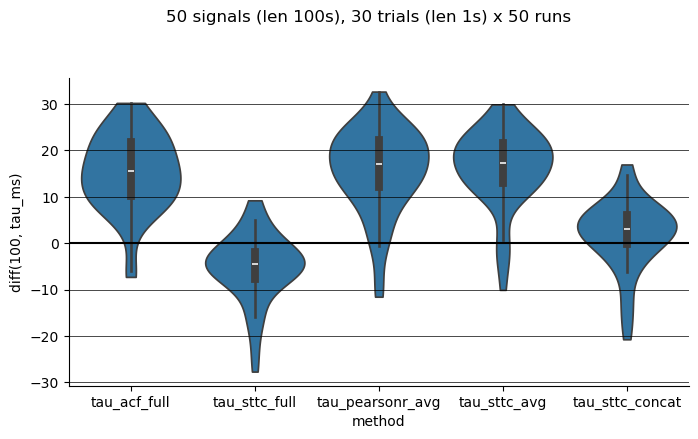

In [37]:
tau_5methods_diff_df_long = pd.melt(tau_5methods_diff_df, id_vars=['signal_id'], value_vars=['tau_acf_full', 'tau_sttc_full', 
                                                                                   'tau_pearsonr_avg', 'tau_sttc_avg', 'tau_sttc_concat'], 
                  value_name='diff(100, tau_ms)', var_name='method')

fig, axes = plt.subplots(1,1, figsize=(8,4))

sns.violinplot(ax=axes, x='method', y='diff(100, tau_ms)', data=tau_5methods_diff_df_long, cut=0,  density_norm='width')
axes.axhline(y=0, color='k')
axes.axhline(y=10, color='k', lw=0.5)
axes.axhline(y=-10, color='k', lw=0.5)
axes.axhline(y=20, color='k', lw=0.5)
axes.axhline(y=-20, color='k', lw=0.5)
axes.axhline(y=30, color='k', lw=0.5)
axes.axhline(y=-30, color='k', lw=0.5)

fig.suptitle('50 signals (len 100s), 30 trials (len 1s) x 50 runs', y=1.05)

sns.despine()

# fig.savefig('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split_parametric\\five_methods\\trial_tau_figs\\' 
#             + 'taus' + str(i) + '.png' , bbox_inches='tight')
fig.savefig('D:\\isttc\\results\\synthetic_data\\test_full_split_parametric\\five_methods_50\\' 
            + 'taus_diff.png' , bbox_inches='tight')

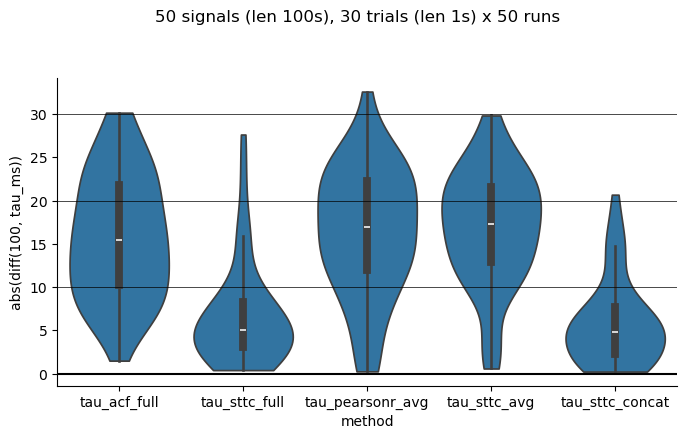

In [43]:
tau_5methods_diff_abs_df_long = pd.melt(tau_5methods_diff_abs_df, id_vars=['signal_id'], value_vars=['tau_acf_full', 'tau_sttc_full', 
                                                                                   'tau_pearsonr_avg', 'tau_sttc_avg', 'tau_sttc_concat'], 
                  value_name='abs(diff(100, tau_ms))', var_name='method')

fig, axes = plt.subplots(1,1, figsize=(8,4))

sns.violinplot(ax=axes, x='method', y='abs(diff(100, tau_ms))', data=tau_5methods_diff_abs_df_long, cut=0,  density_norm='width')
axes.axhline(y=0, color='k')
axes.axhline(y=10, color='k', lw=0.5)
axes.axhline(y=20, color='k', lw=0.5)
axes.axhline(y=30, color='k', lw=0.5)

fig.suptitle('50 signals (len 100s), 30 trials (len 1s) x 50 runs', y=1.05)

sns.despine()

# fig.savefig('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split_parametric\\five_methods\\trial_tau_figs\\' 
#             + 'taus' + str(i) + '.png' , bbox_inches='tight')
fig.savefig('D:\\isttc\\results\\synthetic_data\\test_full_split_parametric\\five_methods_50\\' 
            + 'taus_diff_abs.png' , bbox_inches='tight')